In [23]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [24]:
pdb='./work/ubq.pdb'
trajectory='./work/ubq.desres.s500.dcd'
outdir='./out/'

if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: ./out/
pdb: ./work/ubq.pdb
trjaectory: ./work/ubq.desres.s500.dcd


In [46]:
trj = md.load(trajectory, top=pdb,stride=5)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [26]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'AL

In [27]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [28]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

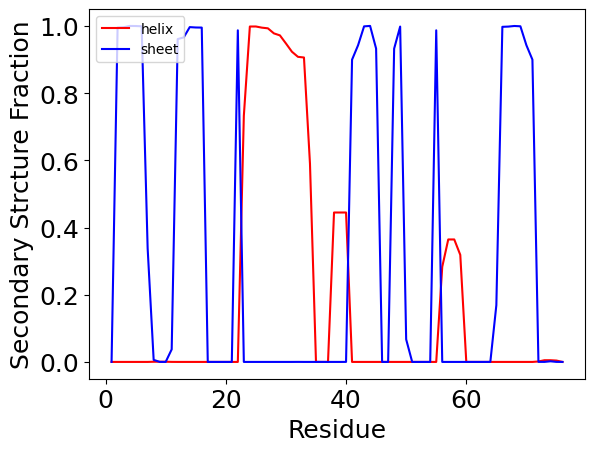

In [29]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


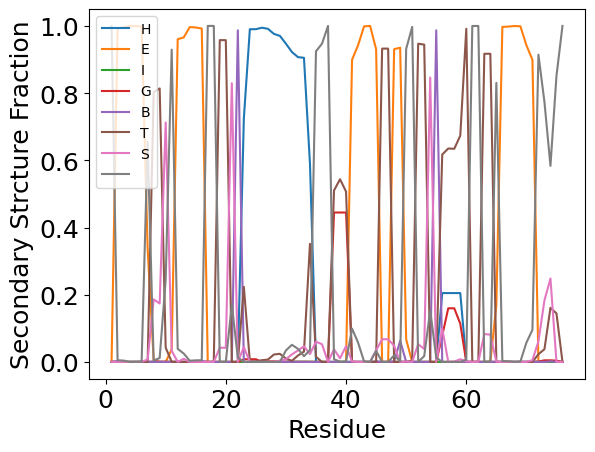

In [30]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [31]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


In [32]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [33]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [34]:
sequence

' [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]'

In [35]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




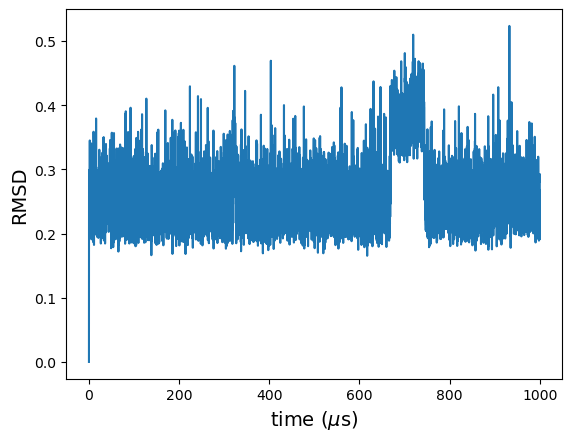

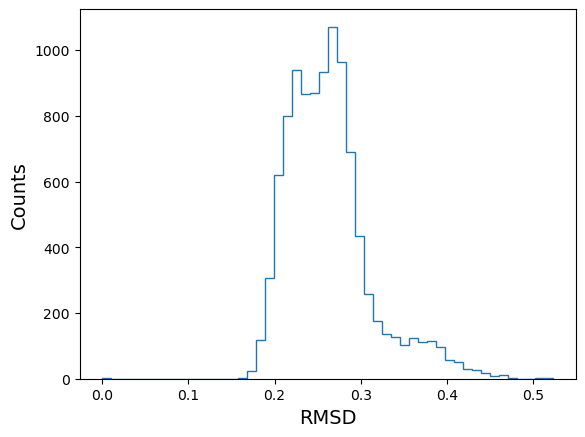

In [38]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

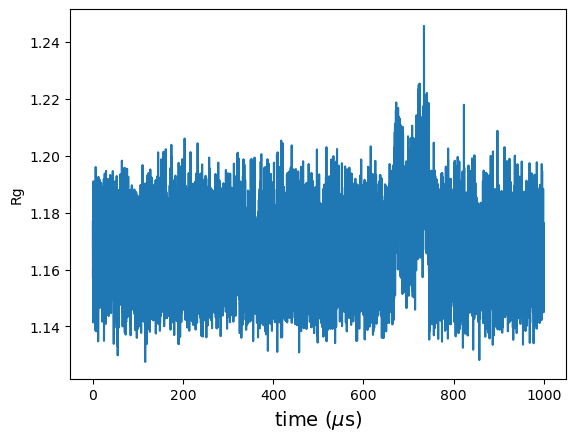

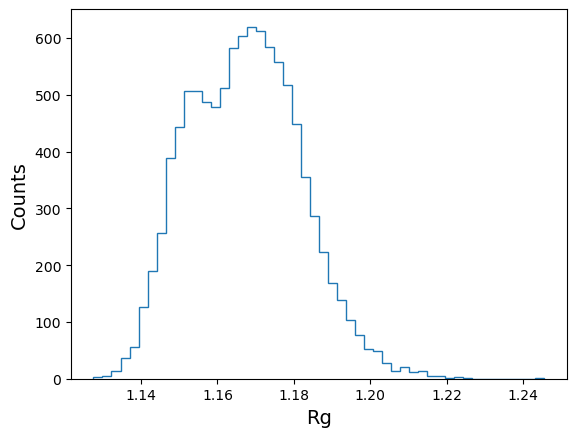

In [40]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [47]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
    

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- PRO38-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- PRO38-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N

In [48]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 351] VAL26-N THR22-O
[400 401 37

[  55   56 1044] PHE4-N SER65-O


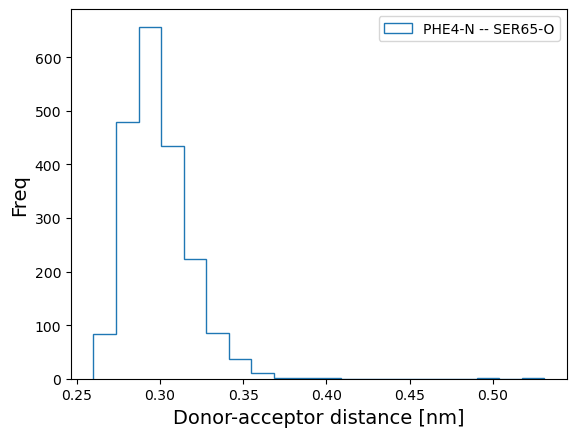

In [49]:
Hbond_index=4
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [56]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(2018, 2)


In [60]:
reduced_cartesian.shape

(2018, 2)

In [61]:
time.shape

(10088,)

In [62]:
np.array(time[::5]).shape

(2018,)

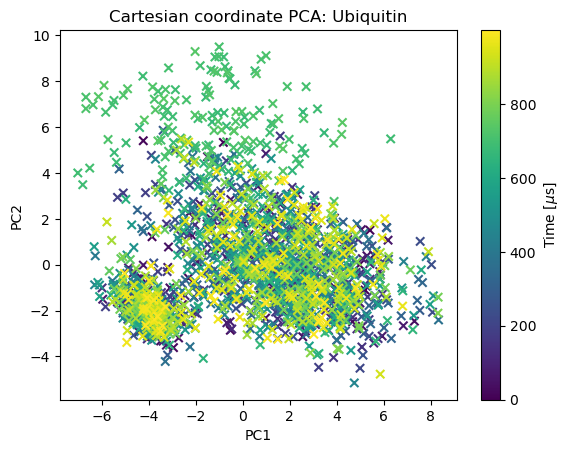

In [59]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time[::5])
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

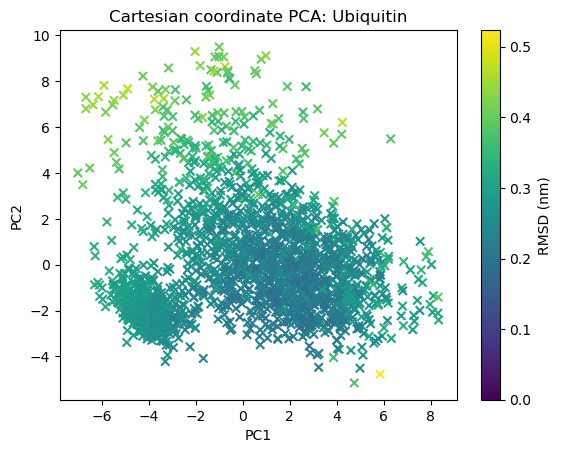

In [64]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd[::5])
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

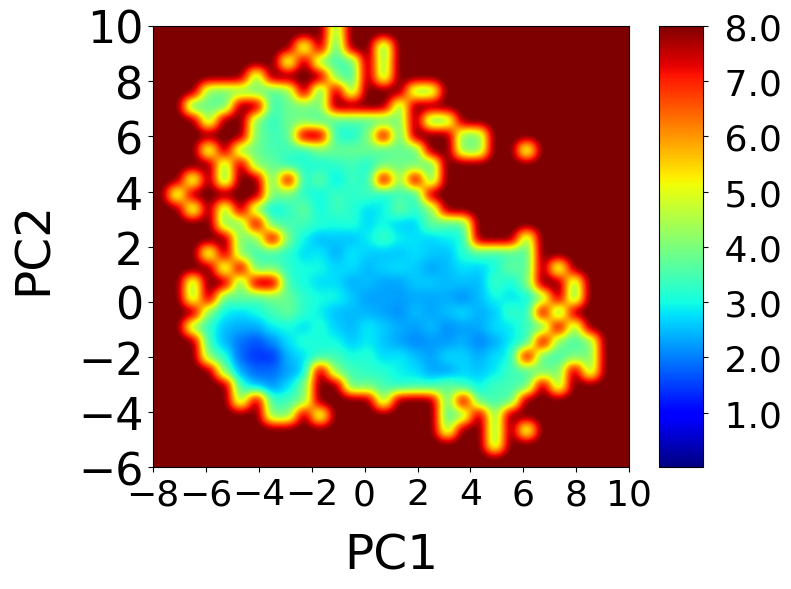

In [65]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

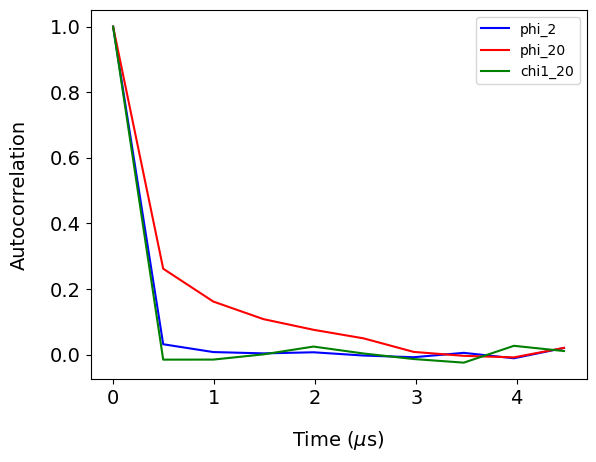

In [66]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

In [ ]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [ ]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)


9) Visualize the most populated clusters from your clustering analysis

Here is the equation used to calculate circular correlation coefficients for dihedral angles

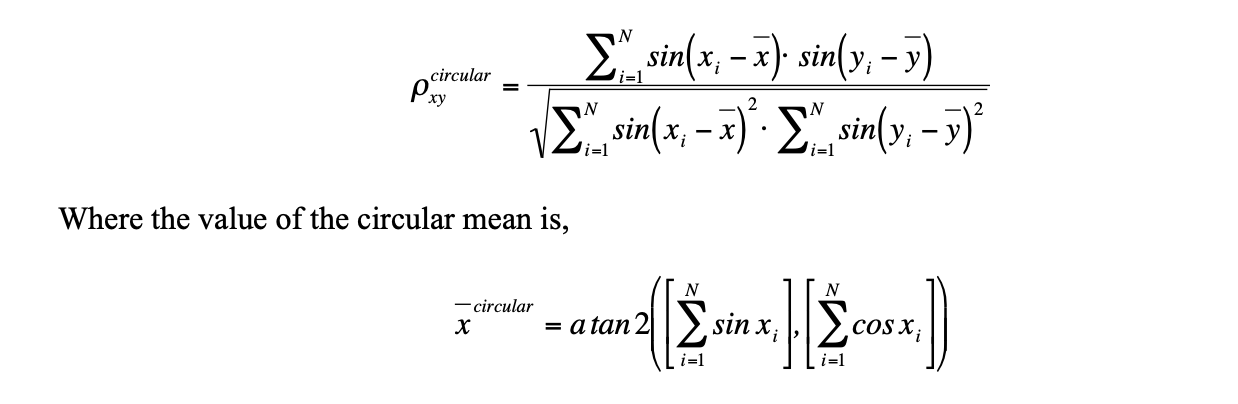


Lets calculate some correlations between dihedrals found in the paper: 


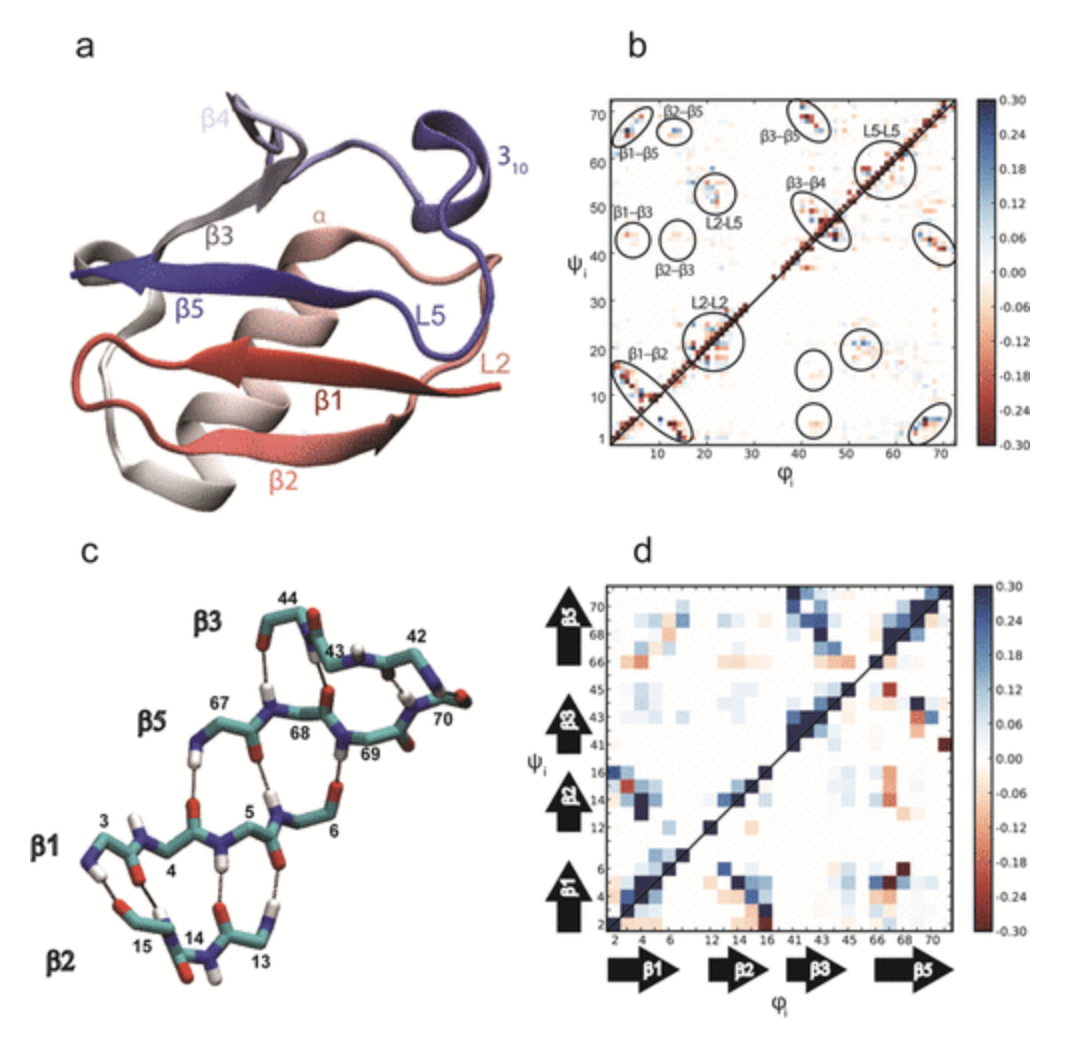